In [1]:
!pip install torchvision==0.8.0

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Thu Mar 25 05:56:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load the MNIST Dataset

In [4]:
'''
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
'''

"\nfrom six.moves import urllib\nopener = urllib.request.build_opener()\nopener.addheaders = [('User-agent', 'Mozilla/5.0')]\nurllib.request.install_opener(opener)\n"

In [5]:
'''
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)
'''

"\n# create transforms\n# We will just convert to tensor and normalize since no special transforms are mentioned in the paper\ntransforms_mnist = transforms.Compose([\n                                       transforms.ToTensor(),\n                                       transforms.Normalize((0.1307,), (0.3081,))\n                                       ])\n\nmnist_data_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=transforms_mnist)\nmnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)\n"

In [6]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST

transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = MNIST(root = '../data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = MNIST(root = '../data/mnist/', train=False, download=True, transform=transforms_mnist)

--2021-03-25 05:56:12--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-25 05:56:13--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
MNIST.tar.gz: Operation not supported

Cannot write to ‘MNIST.tar.gz’ (Success).
tar (child): MNIST.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
Using downloaded and verified file: ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw
Usi

Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [8]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


## Visualize Data

In [9]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [10]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


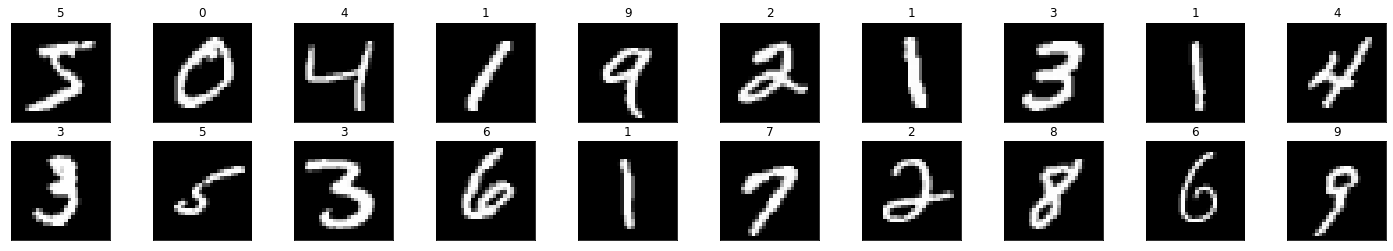

In [11]:
visualize(mnist_data_train)

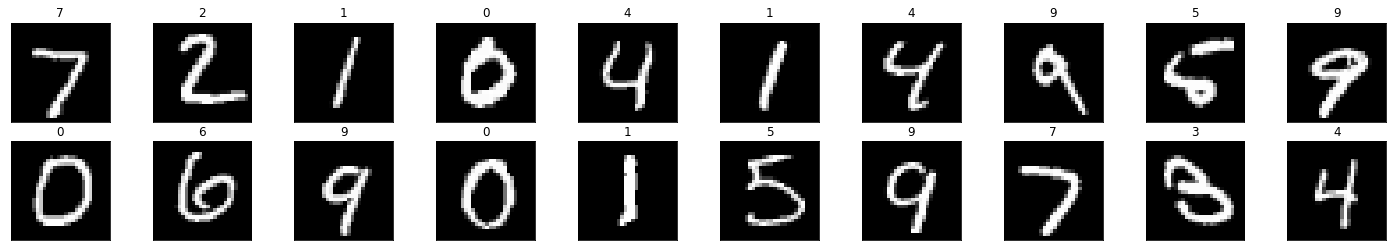

In [12]:
visualize(mnist_data_test)

## Partitioning the Data (IID and non-IID)

In [13]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]
  #data_labels = dataset.targets.numpy()
  #print(data_labels)

  for i in range(clients):
    x = np.random.choice(image_idxs, num_items_per_client, replace=False)
    client_dict[i] = set(x)
    image_idxs = list(set(image_idxs) - client_dict[i])
  '''
  #print(len(client_dict))
  #random.randrange()
  n = []
  cli = list(range(clients))
  for i in range(int(M*clients)):
    new = np.random.choice(cli)
    n.append(new)
    cli.remove(new)
  #n = np.random.choice(range(clients), int(0.1*clients), replace=False)
  #n = list(n)
  print(n)
  for i in n:
    j = 0
    while j < int(W*num_items_per_client):
      l = list(client_dict[i])
      newl = dataset.targets[int(l[j])].item()
      dataset.targets[int(l[j])] = torch.Tensor([(newl+1)%10])

      j += 1

  print(dataset.targets)
  
  c = 0
  for i in dataset.targets:
    if i == torch.Tensor([1]):
      c += 1
  print(c)
  
  '''
  return client_dict


In [14]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  
  #print(data_labels)
  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]
  #print(idxs)
  #print(len(idxs))

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
    #print(client_dict)
  '''
  n = []
  cli = list(range(clients))
  for i in range(int(0.5*clients)):
    new = np.random.choice(cli)
    n.append(new)
    cli.remove(new)
  #n = np.random.choice(range(clients), int(0.1*clients), replace=False)
  #n = list(n)
  print(n)
  for i in n:
    j = 0
    while j < int(0.8*num_shards_per_client):
      l = list(client_dict[i])
      print(l)
      newl = dataset.targets[int(l[j])].item()
      dataset.targets[int(l[j])] = torch.Tensor([1])  #(newl+1)% 10

      j += 1

  print(dataset.targets)

  
  
  M = 0.1
  for n in range(M*K):
    ran = random.randint(0, K)
    for x in data_dict:
      print(len(data_dict[x]))
      #for i in range(0.5*len(data_dict[x])):

  
  '''
  return client_dict





## Models

In [15]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

In [16]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

### Print Model Summaries

In [17]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264

## Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [18]:
import statistics

In [19]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs



  def train(self, model):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

### Server Side Training

Following Algorithm 1 from the paper

In [27]:
def training(model, rounds, batch_size, lr, ds, data_dict, C, K, E, plt_title, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []
  
  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[k])
      weights, loss = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))

    # updating the global weights
    '''
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg
    '''

    ix = 0
    weights = []
    new_w = w
    for k in w[ix].keys():
      l1 = []
      for i in range(len(w)):

          # Fixed Precision
          x1 = w[i][k] * (10**3)
          
          # Flattening weight tensors to lists
          f1 = torch.flatten(x1)
          
          # Converting values to int for our streaming algo 
          f1 = list(map(int, f1))
          
          l1.append(f1)
          #print(len(f1))
          
      # Computing Median
      j = 0
      gl = []
      while j < len(l1[0]):
        nl = []
        for i in range(len(l1)):
          nl.append(l1[i][j])
        m = np.median(nl)
        gl.append(m)
        j += 1

      
      for i in range(len(gl)):
        gl[i] /= (10**3)
      
      newar = np.asarray(gl)
      newar = np.reshape(gl, w[0][k].size())
      #print(newar.shape)
      tens = torch.from_numpy(newar)
      #print(tens)
      weights.append(tens)


      ix += 1

    k = 0
    coun = 0
    for key, value in global_weights.items():
      #print(key)
      #print(global_weights[key].size())
      #print(weights[k].size())
      global_weights[key] = weights[k]
      k += 1
      coun += 1

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

  end = time.time()
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig('/gdrive/My Drive/FedPerf/MNIST/FedAvg/Rounds/' + plt_title +'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model

## Testing Loop

In [22]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
  for i in range(10):
    if total_class[i]>0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i])))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))

# MNIST MLP on IID

### Train

tensor([[ 0.0120,  0.0260,  0.0110,  ...,  0.0020, -0.0160, -0.0250],
        [ 0.0000,  0.0280,  0.0130,  ..., -0.0080, -0.0150, -0.0330],
        [ 0.0345, -0.0205,  0.0045,  ...,  0.0005,  0.0225,  0.0305],
        ...,
        [ 0.0085,  0.0215,  0.0095,  ..., -0.0145, -0.0145,  0.0295],
        [ 0.0235, -0.0350, -0.0230,  ...,  0.0300,  0.0000, -0.0250],
        [ 0.0075, -0.0060, -0.0175,  ..., -0.0265, -0.0345,  0.0325]],
       dtype=torch.float64)
tensor([ 0.0330, -0.0160,  0.0200,  0.0310,  0.0275, -0.0210,  0.0005, -0.0180,
         0.0060, -0.0145, -0.0010, -0.0015, -0.0010, -0.0060,  0.0365, -0.0190,
        -0.0170,  0.0150,  0.0045, -0.0320,  0.0405,  0.0315,  0.0070, -0.0265,
         0.0140, -0.0100, -0.0215,  0.0310, -0.0060, -0.0220, -0.0260,  0.0065,
        -0.0035,  0.0345,  0.0045,  0.0070, -0.0170, -0.0315,  0.0230,  0.0275,
        -0.0130, -0.0200, -0.0155,  0.0020,  0.0445,  0.0055,  0.0045,  0.0055,
         0.0040,  0.0280, -0.0255, -0.0020,  0.0340,  0.01

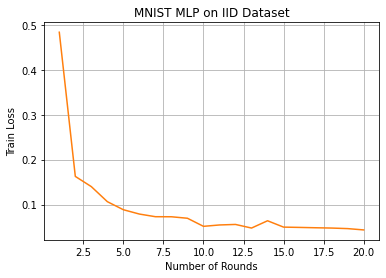

In [23]:
# number of training rounds
rounds = 20
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each round
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.05
# dict containing different type of data partition
data_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, C, K, E, "MNIST MLP on IID Dataset", "orange")


### Test

In [24]:
criterion = nn.CrossEntropyLoss()
testing(mnist_mlp_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 0.111356

Test Accuracy of     0: 98% (75/76)
Test Accuracy of     1: 96% (87/90)
Test Accuracy of     2: 96% (88/91)
Test Accuracy of     3: 95% (70/73)
Test Accuracy of     4: 96% (86/89)
Test Accuracy of     5: 92% (63/68)
Test Accuracy of     6: 96% (60/62)
Test Accuracy of     7: 93% (76/81)
Test Accuracy of     8: 97% (75/77)
Test Accuracy of     9: 98% (82/83)

Final Test  Accuracy: 96.456 (762.0/790.0)


#MNIST MLP on Non-IID

##Train

tensor([[-0.0160,  0.0030,  0.0305,  ..., -0.0010,  0.0020,  0.0170],
        [-0.0080,  0.0080,  0.0170,  ...,  0.0320,  0.0350,  0.0270],
        [-0.0080,  0.0010, -0.0330,  ...,  0.0200,  0.0005,  0.0300],
        ...,
        [-0.0280,  0.0210,  0.0310,  ..., -0.0310, -0.0180,  0.0190],
        [ 0.0000,  0.0300,  0.0050,  ...,  0.0320,  0.0245,  0.0100],
        [ 0.0030,  0.0130,  0.0030,  ...,  0.0330, -0.0050,  0.0220]],
       dtype=torch.float64)
tensor([ 0.0215,  0.0290, -0.0140, -0.0200, -0.0200,  0.0275, -0.0205,  0.0265,
        -0.0305,  0.0055,  0.0250, -0.0330, -0.0335, -0.0040, -0.0280, -0.0025,
        -0.0045, -0.0050,  0.0370,  0.0005, -0.0040,  0.0215, -0.0220, -0.0130,
         0.0170,  0.0165,  0.0070,  0.0220, -0.0100,  0.0235,  0.0125, -0.0170,
         0.0165, -0.0345,  0.0385, -0.0305,  0.0305,  0.0000, -0.0355, -0.0250,
         0.0295,  0.0290,  0.0155, -0.0285,  0.0230,  0.0105,  0.0150, -0.0200,
        -0.0035, -0.0010,  0.0155,  0.0040,  0.0240, -0.02

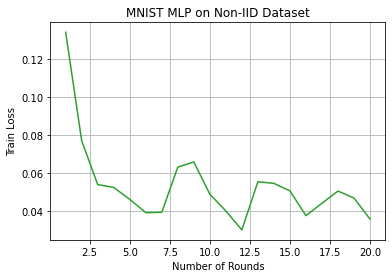

In [25]:
# number of training rounds
rounds = 20
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.05
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_non_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, C, K, E, "MNIST MLP on Non-IID Dataset", "green")

##Test

In [26]:
criterion = nn.CrossEntropyLoss()
testing(mnist_mlp_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 3.094585

Test Accuracy of     0: 98% (75/76)
Test Accuracy of     1: 95% (86/90)
Test Accuracy of     2: 60% (55/91)
Test Accuracy of     3: 38% (28/73)
Test Accuracy of     4: 73% (65/89)
Test Accuracy of     5: 91% (62/68)
Test Accuracy of     6: 82% (51/62)
Test Accuracy of     7: 76% (62/81)
Test Accuracy of     8: 97% (75/77)
Test Accuracy of     9: 31% (26/83)

Final Test  Accuracy: 74.051 (585.0/790.0)


#MNIST CNN on IID

##Train

Round: 1... 	Average Loss: 0.48
Round: 2... 	Average Loss: 0.151
Round: 3... 	Average Loss: 0.079
Round: 4... 	Average Loss: 0.077
Round: 5... 	Average Loss: 0.052
Round: 6... 	Average Loss: 0.054
Round: 7... 	Average Loss: 0.045
Round: 8... 	Average Loss: 0.037
Round: 9... 	Average Loss: 0.038
Round: 10... 	Average Loss: 0.036
Round: 11... 	Average Loss: 0.035
Round: 12... 	Average Loss: 0.032
Round: 13... 	Average Loss: 0.032
Round: 14... 	Average Loss: 0.032
Round: 15... 	Average Loss: 0.025
Round: 16... 	Average Loss: 0.03
Round: 17... 	Average Loss: 0.034
Round: 18... 	Average Loss: 0.024
Round: 19... 	Average Loss: 0.022
Round: 20... 	Average Loss: 0.026
Training Done!
Total time taken to Train: 2663.5631272792816


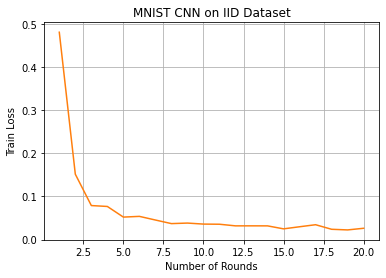

In [28]:
# number of training rounds
rounds = 20
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.05
# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, C, K, E, "MNIST CNN on IID Dataset", "orange")

##Test

In [29]:
criterion = nn.CrossEntropyLoss()
testing(mnist_cnn_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 0.033515

Test Accuracy of     0: 100% (76/76)
Test Accuracy of     1: 100% (90/90)
Test Accuracy of     2: 98% (90/91)
Test Accuracy of     3: 97% (71/73)
Test Accuracy of     4: 100% (89/89)
Test Accuracy of     5: 98% (67/68)
Test Accuracy of     6: 98% (61/62)
Test Accuracy of     7: 100% (81/81)
Test Accuracy of     8: 100% (77/77)
Test Accuracy of     9: 98% (82/83)

Final Test  Accuracy: 99.241 (784.0/790.0)


#MNIST CNN on Non-IID

##Train

Round: 1... 	Average Loss: 0.15
Round: 2... 	Average Loss: 0.134
Round: 3... 	Average Loss: 0.063
Round: 4... 	Average Loss: 0.049
Round: 5... 	Average Loss: 0.052
Round: 6... 	Average Loss: 0.049
Round: 7... 	Average Loss: 0.036
Round: 8... 	Average Loss: 0.036
Round: 9... 	Average Loss: 0.042
Round: 10... 	Average Loss: 0.038
Round: 11... 	Average Loss: 0.033
Round: 12... 	Average Loss: 0.035
Round: 13... 	Average Loss: 0.03
Round: 14... 	Average Loss: 0.033
Round: 15... 	Average Loss: 0.028
Round: 16... 	Average Loss: 0.029
Round: 17... 	Average Loss: 0.024
Round: 18... 	Average Loss: 0.029
Round: 19... 	Average Loss: 0.022
Round: 20... 	Average Loss: 0.02
Training Done!
Total time taken to Train: 2645.322196960449


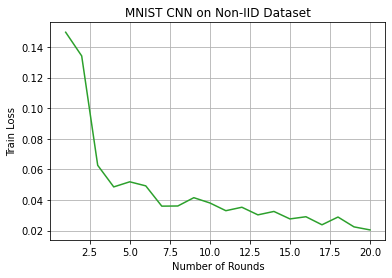

In [30]:
rounds = 20
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.05
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, C, K, E, "MNIST CNN on Non-IID Dataset", "green")

##Test

In [31]:
criterion = nn.CrossEntropyLoss()
testing(mnist_cnn_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 0.568321

Test Accuracy of     0: 100% (76/76)
Test Accuracy of     1: 97% (88/90)
Test Accuracy of     2: 97% (89/91)
Test Accuracy of     3: 97% (71/73)
Test Accuracy of     4: 98% (88/89)
Test Accuracy of     5: 86% (59/68)
Test Accuracy of     6: 87% (54/62)
Test Accuracy of     7: 76% (62/81)
Test Accuracy of     8: 93% (72/77)
Test Accuracy of     9: 75% (63/83)

Final Test  Accuracy: 91.392 (722.0/790.0)
